In [1]:
using Pkg, Revise
Pkg.activate(".")

  Activating environment at `~/Desktop/SelectivelyAdaptiveLasso/Project.toml`


In [45]:
using CSV

In [80]:
data = CSV.read(open("/Users/aschuler/Downloads/winequality-red.csv"), DataFrame, copycols=true)
Y = float(data.quality)
Y = Y .- mean(Y)
X = Matrix(data[:,[var for var in names(data) if var ≠ "quality"]]);

n_val = Int(round(length(Y)/2))
X_val, Y_val = X[1:n_val,:], Y[1:n_val]
X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

In [2]:
using VegaLite, DataFrames

In [3]:
import Statistics: mean
import Distributions as Dist
import LinearAlgebra: diagm

n, p = 5000, 10

X_dist = Dist.reshape(
    Dist.MvNormal(zeros(p), 0.1ones(p,p) + 0.9diagm(ones(p))), 
    (1,p)
)
ϵ_dist = Dist.Normal(0,1)

X = vcat(rand(X_dist, n)...)
ϵ = rand(ϵ_dist, n)

Y = 5X[:,1] + X[:,2].^2 - 3X[:,3].*X[:,4] + ϵ
Y = Y .- mean(Y)

n_val = Int(round(n/2))
X_val, Y_val = X[1:n_val,:], Y[1:n_val]
X, Y = X[(n_val+1):end,:], Y[(n_val+1):end];

# xgboost

In [4]:
using XGBoost

In [81]:
B = 1001
bst = xgboost(X, B, label = Y, eta = 0.01, max_depth = 3);

[1]	train-rmse:0.928552
[2]	train-rmse:0.924153
[3]	train-rmse:0.919854
[4]	train-rmse:0.915585
[5]	train-rmse:0.911371
[6]	train-rmse:0.907255
[7]	train-rmse:0.903193
[8]	train-rmse:0.899157
[9]	train-rmse:0.894977
[10]	train-rmse:0.891051
[11]	train-rmse:0.886982
[12]	train-rmse:0.883125
[13]	train-rmse:0.879164
[14]	train-rmse:0.875470
[15]	train-rmse:0.871611
[16]	train-rmse:0.867981
[17]	train-rmse:0.864223
[18]	train-rmse:0.860653
[19]	train-rmse:0.856994
[20]	train-rmse:0.853527
[21]	train-rmse:0.850103
[22]	train-rmse:0.846583
[23]	train-rmse:0.843263
[24]	train-rmse:0.839757
[25]	train-rmse:0.836425
[26]	train-rmse:0.833088
[27]	train-rmse:0.829929
[28]	train-rmse:0.826584
[29]	train-rmse:0.823502
[30]	train-rmse:0.820265
[31]	train-rmse:0.817122
[32]	train-rmse:0.814162
[33]	train-rmse:0.811053
[34]	train-rmse:0.808179
[35]	train-rmse:0.805193
[36]	train-rmse:0.802299
[37]	train-rmse:0.799537
[38]	train-rmse:0.796605
[39]	train-rmse:0.793749
[40]	train-rmse:0.791065
[41]	trai

In [82]:
ntrees = 1:B # 1:100:B
bst_val_loss = map(ntrees) do ntree
    Ŷ = predict(bst, X_val, ntree_limit=ntree)
    mean((Y_val - Ŷ).^2)
end;

In [83]:
df_xgb = DataFrame(
    n_iter = ntrees,
    loss = bst_val_loss,
    learner = "XGBoost",
);

In [84]:
findmin(bst_val_loss)

(0.401185902518711, 309)

# SAL

In [70]:
import SelectivelyAdaptiveLasso as SAL

In [89]:
sal_spec = SAL.SALSpec(
    max_iter=1000,
    λ = 0.003,
    bases_per_iter=1,
    m_subsample=400,
    n_subsample=400,
    tol = 1e-3,
)
@time sal_fit, log = SAL.fit(
    sal_spec, 
    X, Y, 
    X_val=X_val, Y_val=Y_val,
    verbose=true, print_iter=10,
)
loss, loss_val = log;

(0.5750812941536394, 0.5281623962042883)
(0.5009448589474125, 0.47389130286226416)
(0.4901465357594598, 0.46544671464177745)
(0.47674583301950046, 0.46208196293476383)
(0.47337513645498003, 0.4674629033034129)
(0.4575750046869093, 0.4413812637126433)
(0.424119109315623, 0.4254080845184133)
(0.42208644901143383, 0.4239889397156752)
(0.41246321479038245, 0.4234471131079517)
(0.41261740333786134, 0.42560152014171626)
(0.4123077624043015, 0.42248706480906106)
(0.4123230931799208, 0.4226757104339473)
(0.4110208528511203, 0.4212731302290094)
(0.4034006393857332, 0.42467832720354887)
(0.3999941872177804, 0.4281685376755132)
(0.3991641462560885, 0.42849765934821155)
(0.3988888383836092, 0.4295458878892211)
(0.3953916544385736, 0.42400073010811007)
(0.39441778609439115, 0.4244517038201882)
(0.39253613069490106, 0.42523860939246483)
(0.39187603213196115, 0.42728453563121754)
(0.39073967864031367, 0.4268723079626364)
(0.3896430469338219, 0.4268788583604097)
(0.389307904728694, 0.42682527301218054

In [102]:
# sal_spec = SAL.SALSpec(
#     max_iter=1000,
#     λ = 0.0001,
#     m_subsample=400,
#     n_subsample=400
# )
# @time sal_fit, log = SAL.fit(
#     sal_spec, 
#     X, Y, 
#     X_val=X_val, Y_val=Y_val,
#     sal_fit = sal_fit,
#     verbose=true, print_iter=100,
# )
# loss, loss_val, _, _ = log;

In [90]:
findmin(loss_val)

(0.41442377909327704, 864)

In [91]:
df_sal = DataFrame(
    n_iter = 1:length(loss_val),
    loss = loss_val,
    learner = "SAL"
);

# Plot

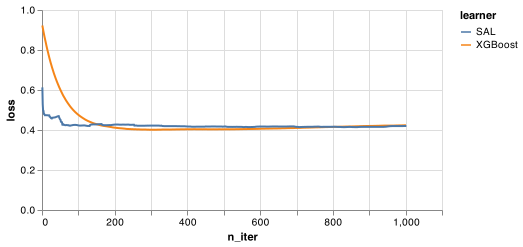

In [92]:
df = vcat(df_xgb, df_sal);
df |>
@vlplot(
    :line,
    x=:n_iter,
    y=:loss,
    color=:learner,
    width=400,
    height=200
)